In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Antithetic Variance Reduction ###

Acceptably accurate estimate of option price typically requires a large nuber of Monte Carlo simulations.

Variance reduction techniques address this issue by improving accuarcy and convergence.

Antithetic variance reduction technique considers a portfolio of two same options written on two perfectly negatively correlated assets having the same initial price $S_{0}$.

$$
dS_{\pm} = r Sdt \pm \sigma Sdw
$$

Although the value of the two options are identical, the variance of the payoff of the above portfolio is much less than the variance of the individual option(s) payoff. This fact is used to obtain a much more accurate estimate of the option price with the same effective number of simulations.

In [3]:
def S1AV_GBM(S0: float, mu: list, sigma: list, T: float, nsteps: int, nsim: int) -> list:
    '''
    Generate oppositely correlated asset price array (antithetic variate)

    S0: initial asset price
    mu: mean rate of asset return
    sigma: asset volatility
    T: time period
    nsteps: number of steps
    nsim: number of simulation of the asset price process
    '''
    dt = T/nsteps
    dw = np.sqrt(dt)*np.random.standard_normal(size=(nsim,nsteps)) # generate the (nsim, nsteps) brownian motion sample
    dz = (mu-0.5*sigma**2)*dt + sigma*dw
    dz_ =  (mu-0.5*sigma**2)*dt - sigma*dw # negatively correlated asset

    Sn = np.exp(np.cumsum(dz, axis=1)) # generate the (nsim, nsteps) geometric brownian momtion price process
    Sn_ = np.exp(np.cumsum(dz_, axis=1))

    Sn=np.vstack((Sn, Sn_))
    Sn = S0*np.concatenate((np.ones(shape=(2*nsim,1)),Sn), axis=1) # add the initial value

    return (Sn)

In [4]:
def MCAV_Euro(S0: float, K: float, r: float, sigma: float, div: float, T: float, Nsteps: int, Nsim: int, optype: str) -> float:
    '''
    Monte Carlo estimate with antithetic variance reduction

    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Nsteps: number of time steps to maturity
    Nsim: number of independent simulations to average
    optype: option type ('call' or 'put')
    '''
        
    mu = r-div

    dt = T/Nsteps
    nu = (r-div)-0.5*sigma**2
    dfact = r*dt + np.zeros(Nsteps)

    # parameter exception
    if ((0<r) and (0<sigma) and (0<=div)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    Smat = S1AV_GBM(S0=S0, mu=mu, sigma=sigma, T=T, nsteps=Nsteps, nsim=Nsim)
    Sarr = Smat[:,-1] # stock price at maturity
    Parr = Sarr-K # payoff

    if optype == 'call':
        Parr[Parr<0] = 0
        Parr = Parr
    elif optype == 'put':
        Parr[Parr>0] = 0
        Parr = -Parr
    else: raise Exception('optype must be call or put')

    V0arr = np.exp(-np.sum(dfact))*Parr

    return(np.mean(V0arr))   


In [50]:
price=MCAV_Euro(S0=100, K=100, r=0.06, sigma=0.2, div=0.03, T=1, Nsteps=10, Nsim=500, optype='call')
print(np.round(price,3))

9.452


Text(0.5, 1.0, 'price convergence: MonteCarlo_antithetic')

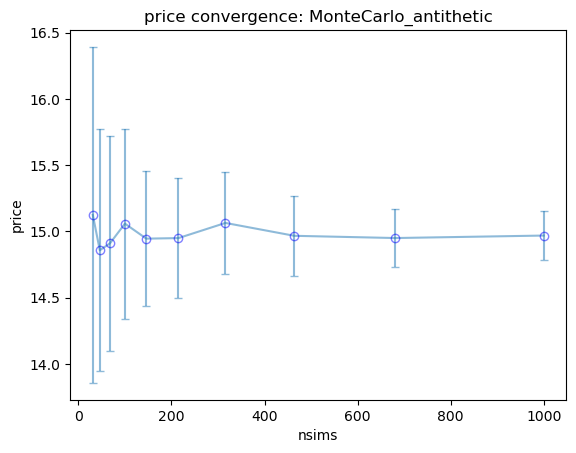

In [6]:
# calculate parameters
S0=100
K=90
r=0.06
sigma=0.2
div=0.03
T=1
Nsteps=300

NSims=np.logspace(1.5,3,10).astype(int) # simulation sizes

price_mean=[]
price_std=[]
for nsim in NSims:
    price_arr=[]
    for ntrials in range(100):
        price=MCAV_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=1, Nsteps=Nsteps, Nsim=nsim, optype='call') # Monte Carlo with antithetic variance reduction
        price_arr.append(price)
    price_mean.append(np.mean(price_arr))
    price_std.append(np.std(price_arr))
    
# plot
fig,ax = plt.subplots()
ax.errorbar(NSims, price_mean, yerr=price_std, marker='o', mfc='None', mec='blue', capsize=3, alpha=0.5)
ax.set_xlabel('nsims')
ax.set_ylabel('price')
ax.set_title('price convergence: MonteCarlo_antithetic')